In [28]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [29]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [30]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']
phastcons = od+config['ref']['phastcons100']['txt']


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
m_cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='mouse')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = od+config['ref']['orth_genes']

mouse_ver = 'vM25_cerberus'

In [33]:
# major isoform triplets mouse match 
h_source = 'obs_mm_major'
m_source = 'obs_major'
gene_subset = ['protein_coding']
h_ver='v40_cerberus'
m_ver='vM25_cerberus'

## Get the genes that are splicing high in human and not in mouse

In [31]:
df = pd.read_csv(human_mouse_sect_cons, sep='\t')
print(len(df.index))
df['sector_conserved'] = df.sector_human == df.sector_mouse
df['splicing_conserved']  = (df.sector_human=='splicing')&(df.sector_mouse=='splicing')
gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist()

13494


In [32]:
# ## get boundaries for each gene
# gtf_df = pr.read_gtf(gtf, as_df=True, duplicate_attr=True, rename_attr=True)

# # read in alus
# alu_df = pr.read_bed(alu)

# alu_df = alu_df.df
# alu_df['alu_len'] = (alu_df['Start']-alu_df['End']).abs()

# # sns.displot(alu_df, x='alu_len', kind='hist')

# alu_df = pr.PyRanges(alu_df)
# gtf_df = cerberus.add_stable_gid(gtf_df)
# gtf_df = gtf_df.loc[gtf_df.Feature == 'gene']
# gtf_df.head()
# type(gtf_df)
# alu_df.head()
# type(alu_df)

# # intersect gene boundaries w/ alu elements and count up alus / kb
# gtf_df = pr.PyRanges(gtf_df)
# temp = gtf_df.join(alu_df,
#                    strandedness='same',
#                    how='left',
#                    report_overlap=True,
#                    slack=0)

# temp = temp.df


# temp = pd.read_csv('alu_gtf_intersect.tsv', sep='\t')

In [33]:
temp = pd.read_csv('alu_gtf_intersect.tsv', sep='\t')

In [34]:
len(temp.gene_id.unique())

34176

In [35]:
temp['overlaps_alu'] = temp.Overlap==temp.alu_len

In [36]:
# temp.loc[temp.gene_id.duplicated(keep=False)].sort_values(by='gene_id').head()

In [37]:
temp['gene_len'] = (temp.Start-temp.End).abs()
temp2 = temp[['gene_id', 'gene_name', 'gene_len', 'overlaps_alu']].groupby(['gene_id', 'gene_name', 'gene_len']).sum().reset_index().rename({'overlaps_alu': 'n_overlapping_alu'}, axis=1)

In [38]:
# limit just to the orthologs
# get all ortholog calls
all_gids = df['Gene stable ID'].tolist()
print(len(all_gids))
temp2 = temp2.loc[temp2.gene_id.isin(all_gids)]

13494


In [39]:
temp2['changed_sect'] = temp2.gene_id.isin(gids)

In [40]:
temp2.head()

,gene_id,gene_name,gene_len,n_overlapping_alu,changed_sect
0,ENSG00000000003,TSPAN6,10097,2,False
1,ENSG00000000005,TNMD,15184,1,False
3,ENSG00000000457,SCYL3,44737,7,False
4,ENSG00000000460,C1orf112,59451,12,False
5,ENSG00000000938,FGR,23903,7,False


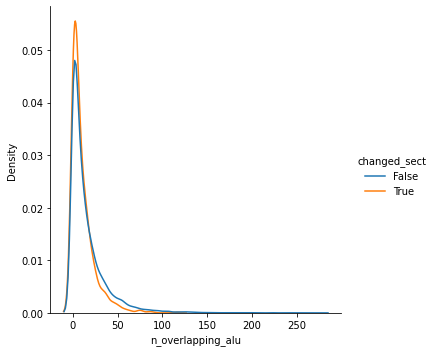

In [41]:
sns.displot(temp2, x='n_overlapping_alu', hue='changed_sect', kind='kde', common_norm=False)

In [42]:
temp2['alus_per_kb'] = ((temp2.n_overlapping_alu)*1000)/temp2.gene_len

In [43]:
temp2.loc[temp2.gene_name=='ELN']

,gene_id,gene_name,gene_len,n_overlapping_alu,changed_sect,alus_per_kb
649,ENSG00000049540,ELN,42219,30,True,0.710581


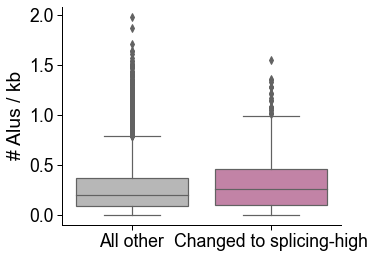

In [44]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5,4))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
new_c_dict = {'Changed to splicing-high': c_dict['splicing'],
             'All other':  c_dict['mixed']}
d2 = {True: 'Changed to splicing-high',
      False: 'All other'}
temp2['gene_status'] = temp2.changed_sect.map(d2)
# ax = sns.displot(temp2, x='alus_per_kb', hue='gene_status',
#                  palette=new_c_dict,
#                  kind='kde', common_norm=False,
#                 linewidth=3)
ax = sns.boxplot(temp2, y='alus_per_kb', x='gene_status',
                 palette=new_c_dict)
ax.set(xlabel='', ylabel='# Alus / kb')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('figures/alus_human_mouses.pdf', dpi=500, bbox_inches='tight')

In [45]:
temp2.to_csv('mouse_human_alus.tsv', sep='\t')

In [46]:
temp2[['alus_per_kb', 'changed_sect']].groupby('changed_sect').mean()

,alus_per_kb
changed_sect,
False,0.256255
True,0.308133


In [47]:
a = temp2.loc[temp2.changed_sect==True].alus_per_kb.tolist()
b = temp2.loc[temp2.changed_sect==False].alus_per_kb.tolist()
st.kstest(a,b,alternative='two-sided')

KstestResult(statistic=0.11790267345822902, pvalue=3.4964091865816716e-10)

In [48]:
a = temp2.loc[temp2.changed_sect==True].alus_per_kb.tolist()
b = temp2.loc[temp2.changed_sect==False].alus_per_kb.tolist()
st.mannwhitneyu(a,b,alternative='two-sided')

MannwhitneyuResult(statistic=5976743.0, pvalue=4.570313866588192e-07)

In [49]:
a = temp2.loc[temp2.changed_sect==True].alus_per_kb.tolist()
b = temp2.loc[temp2.changed_sect==False].alus_per_kb.tolist()
st.ttest_ind(a,b,alternative='two-sided')

Ttest_indResult(statistic=6.168347318155988, pvalue=7.097883158127631e-10)

In [50]:
# scatter plot of splicing_ratio, n_ic vs. alus_per_kb, also for sectors
source = 'obs_det'
ca = cerberus.read(cerberus_h5)
temp3 = ca.triplets.loc[ca.triplets.source==source]

In [51]:
len(temp3.gid.unique())

26544

In [52]:
temp['gene_len'] = (temp.Start-temp.End).abs()
temp2 = temp[['gene_id', 'gene_name', 'gene_len', 'overlaps_alu']].groupby(['gene_id', 'gene_name', 'gene_len']).sum().reset_index().rename({'overlaps_alu': 'n_overlapping_alu'}, axis=1)
temp2['alus_per_kb'] = ((temp2.n_overlapping_alu)*1000)/temp2.gene_len

In [53]:
temp2.head()

,gene_id,gene_name,gene_len,n_overlapping_alu,alus_per_kb
0,ENSG00000000003,TSPAN6,10097,2,0.198079
1,ENSG00000000005,TNMD,15184,1,0.065859
2,ENSG00000000419,DPM1,25738,11,0.427384
3,ENSG00000000457,SCYL3,44737,7,0.156470
4,ENSG00000000460,C1orf112,59451,12,0.201847


In [54]:
temp3.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
0,obs_det,ENSG00000000003,1.0,6.0,9.0,29.0,2.571429,0.104478,0.626866,0.268657,tes,TSPAN6,NaN,NaN
1,obs_det,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TNMD,NaN,NaN
2,obs_det,ENSG00000000419,2.0,3.0,8.0,10.0,3.200000,0.243902,0.365854,0.390244,mixed,DPM1,NaN,NaN
3,obs_det,ENSG00000000457,3.0,4.0,5.0,7.0,1.428571,0.355932,0.474576,0.169492,mixed,SCYL3,NaN,NaN
4,obs_det,ENSG00000000460,3.0,4.0,6.0,17.0,1.714286,0.344262,0.459016,0.196721,mixed,C1orf112,NaN,NaN


In [55]:
temp3 = temp3.merge(temp2, how='left', left_on='gid', right_on='gene_id')

In [56]:
temp3.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,gene_id,gene_name,gene_len,n_overlapping_alu,alus_per_kb
0,obs_det,ENSG00000000003,1.0,6.0,9.0,29.0,2.571429,0.104478,0.626866,0.268657,tes,TSPAN6,NaN,NaN,ENSG00000000003,TSPAN6,10097,2,0.198079
1,obs_det,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TNMD,NaN,NaN,ENSG00000000005,TNMD,15184,1,0.065859
2,obs_det,ENSG00000000419,2.0,3.0,8.0,10.0,3.200000,0.243902,0.365854,0.390244,mixed,DPM1,NaN,NaN,ENSG00000000419,DPM1,25738,11,0.427384
3,obs_det,ENSG00000000457,3.0,4.0,5.0,7.0,1.428571,0.355932,0.474576,0.169492,mixed,SCYL3,NaN,NaN,ENSG00000000457,SCYL3,44737,7,0.156470
4,obs_det,ENSG00000000460,3.0,4.0,6.0,17.0,1.714286,0.344262,0.459016,0.196721,mixed,C1orf112,NaN,NaN,ENSG00000000460,C1orf112,59451,12,0.201847


<AxesSubplot:xlabel='sector', ylabel='alus_per_kb'>

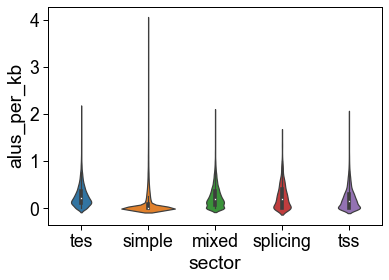

In [57]:
sns.violinplot(temp3, y='alus_per_kb', x='sector')

In [58]:
import itertools
pairs = list(itertools.combinations(temp3.sector.unique().tolist(), 2))
c1 = [c[0] for c in pairs]
c2 = [c[1] for c in pairs]

In [59]:
# t test
for sect1, sect2 in zip(c1, c2):
    v1 = temp3.loc[temp3.sector==sect1, 'alus_per_kb'].tolist()
    v2 = temp3.loc[temp3.sector==sect2, 'alus_per_kb'].tolist()
    result = st.mannwhitneyu(v1, v2, alternative='two-sided')
    p = result.pvalue
    stat = result.statistic
    print(f'{sect1} vs. {sect2}: p={p}, stat={stat}')
    print(f'{sect1} vs. {sect2}: p={p}')
    print()

tes vs. simple: p=0.0, stat=35863779.5
tes vs. simple: p=0.0

tes vs. mixed: p=1.427955841842466e-10, stat=25111508.5
tes vs. mixed: p=1.427955841842466e-10

tes vs. splicing: p=3.069370055264327e-05, stat=3294872.5
tes vs. splicing: p=3.069370055264327e-05

tes vs. tss: p=1.3903959070565127e-39, stat=7163257.5
tes vs. tss: p=1.3903959070565127e-39

simple vs. mixed: p=0.0, stat=19571588.0
simple vs. mixed: p=0.0

simple vs. splicing: p=8.194274003941285e-191, stat=2840187.0
simple vs. splicing: p=8.194274003941285e-191

simple vs. tss: p=1.7035610869101985e-261, stat=6010414.5
simple vs. tss: p=1.7035610869101985e-261

mixed vs. splicing: p=0.29350592758585425, stat=5490654.0
mixed vs. splicing: p=0.29350592758585425

mixed vs. tss: p=3.6396376919590537e-19, stat=11884342.5
mixed vs. tss: p=3.6396376919590537e-19

splicing vs. tss: p=8.406709495566682e-06, stat=1501058.5
splicing vs. tss: p=8.406709495566682e-06



## What about the intron size?

In [43]:
# human intron length
gtf_df = pr.read_gtf(cerb_gtf,
                     rename_attr=True,
                     duplicate_attr=True)
ca = cerberus.read(cerberus_h5)
biotype_info, _, _ = get_gtf_info(add_stable_gid=True)

gids = biotype_info.loc[biotype_info.biotype==gene_subset[0], 'gid_stable'].tolist()
ca.triplets = ca.triplets.loc[ca.triplets.gid.isin(gids)]
introns = gtf_df.features.introns(by='transcript').df
introns['len'] = (introns.Start-introns.End).abs()
introns = introns[['gene_id', 'transcript_id', 'len']].groupby(['gene_id', 'transcript_id']).sum().reset_index()
introns = introns[['gene_id', 'len']].groupby('gene_id').mean().reset_index().rename({'len':'mean_intron_len'}, axis=1)
introns = cerberus.add_stable_gid(introns)
df = ca.triplets.loc[ca.triplets.source==h_source].copy()
df = df.merge(introns, how='left', left_on='gid', right_on='gene_id')

df['log_mean_intron_len'] = np.log2(df['mean_intron_len'])
intron_df = df.copy(deep=True)
intron_df.to_csv('human_intron_len.tsv', sep='\t')

In [35]:
# mouse intron length
m_gtf_df = pr.read_gtf(m_cerb_gtf,
                     rename_attr=True,
                     duplicate_attr=True)
m_ca = cerberus.read(m_cerberus_h5)
biotype_info, _, _ = get_gtf_info(ver=m_ver, add_stable_gid=True)
gids = biotype_info.loc[biotype_info.biotype==gene_subset[0], 'gid_stable'].tolist()
m_ca.triplets = m_ca.triplets.loc[m_ca.triplets.gid.isin(gids)]
m_introns = m_gtf_df.features.introns(by='transcript').df
m_introns['len'] = (m_introns.Start-m_introns.End).abs()
m_introns = m_introns[['gene_id', 'transcript_id', 'len']].groupby(['gene_id', 'transcript_id']).sum().reset_index()
m_introns = m_introns[['gene_id', 'len']].groupby('gene_id').mean().reset_index().rename({'len':'mean_intron_len'}, axis=1)
m_introns = cerberus.add_stable_gid(m_introns)

m_df = m_ca.triplets[m_ca.triplets.source=='m_source'].copy()
m_df = m_df.merge(m_introns, how='left', left_on='gid', right_on='gene_id')

m_df['log_mean_intron_len'] = np.log2(m_df['mean_intron_len'])
m_intron_df = m_df.copy(deep=True)
m_intron_df.to_csv('mouse_intron_len.tsv', sep='\t')

In [197]:
m_intron_df.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,gene_id,mean_intron_len,log_mean_intron_len
0,obs_det,ENSMUSG00000000001,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,simple,Gnai3,NaN,NaN,ENSMUSG00000000001,35605.000000,15.119792
1,obs_det,ENSMUSG00000000028,3.0,2.0,6.0,8.0,2.4,0.405405,0.270270,0.324324,mixed,Cdc45,NaN,NaN,ENSMUSG00000000028,29485.428571,14.847715
2,obs_det,ENSMUSG00000000037,3.0,2.0,8.0,16.0,3.2,0.365854,0.243902,0.390244,mixed,Scml2,NaN,NaN,ENSMUSG00000000037,98513.000000,16.588026
3,obs_det,ENSMUSG00000000049,1.0,1.0,2.0,2.0,2.0,0.250000,0.250000,0.500000,mixed,Apoh,NaN,NaN,ENSMUSG00000000049,17915.000000,14.128880
4,obs_det,ENSMUSG00000000056,1.0,2.0,3.0,6.0,2.0,0.200000,0.400000,0.400000,mixed,Narf,NaN,NaN,ENSMUSG00000000056,12245.714286,13.579989


In [198]:
# major isoform triplets mouse match 
h_source = 'obs_mm_major'
m_source = 'obs_major'
gene_subset = ['protein_coding']
h_ver='v40_cerberus'
m_ver='vM25_cerberus'

# read in triplets and limit to source
ca = cerberus.read(cerberus_h5)
h_df = ca.triplets.loc[ca.triplets.source == h_source]

ca = cerberus.read(m_cerberus_h5)
m_df = ca.triplets.loc[ca.triplets.source == m_source]

def subset_on_dict(df, subset):
    for col, val in subset.items():
            if type(val) != list:
                val = [val]
            df = df.loc[df[col].isin(val)]
    return df

# # limit to samples if given
# if h_subset:
#     h_df = subset_on_dict(h_df, h_subset)
# if m_subset:
#     m_df = subset_on_dict(m_df, m_subset)

# get sectors for each gene
h_df = assign_gisx_sector(h_df)
m_df = assign_gisx_sector(m_df)

# merge in gene info and subset
if gene_subset:
    gene_df, _, _ = get_gtf_info(how='gene', ver=h_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    h_df = h_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    gene_df, _, _ = get_gtf_info(how='gene', ver=m_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    m_df = m_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    h_df = h_df.loc[h_df.biotype_category.isin(gene_subset)]
    m_df = m_df.loc[m_df.biotype_category.isin(gene_subset)]

# get matching gids from human and mouse
# d = os.path.dirname(__file__)
# fname = '../ref/biomart_human_to_mouse.tsv'
df = get_human_mouse_gid_table(orth_table)

df = df.merge(h_df, how='right', left_on='Gene stable ID',
              right_on='gid')

df = df.merge(m_df, how='right', left_on='Mouse gene stable ID',
              right_on='gid', suffixes=('_human', '_mouse'))

# get only genes that are both expressed
df = df.loc[~(df.sector_human.isnull())&~(df.sector_mouse.isnull())]


# get all ortholog calls
all_gids = df['Gene stable ID'].tolist()
print(len(all_gids))

# limit to splicing-->!splicing
gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist() 
print(len(gids))

13494
858


In [199]:
m_intron_df.rename({'mean_intron_len':'m_mean_intron_len',
                    'log_mean_intron_len':'m_log_mean_intron_len',
                    'gid':'Mouse gene stable ID'}, axis=1, inplace=True)
m_intron_df.head()

,source,Mouse gene stable ID,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,gene_id,m_mean_intron_len,m_log_mean_intron_len
0,obs_det,ENSMUSG00000000001,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,simple,Gnai3,NaN,NaN,ENSMUSG00000000001,35605.000000,15.119792
1,obs_det,ENSMUSG00000000028,3.0,2.0,6.0,8.0,2.4,0.405405,0.270270,0.324324,mixed,Cdc45,NaN,NaN,ENSMUSG00000000028,29485.428571,14.847715
2,obs_det,ENSMUSG00000000037,3.0,2.0,8.0,16.0,3.2,0.365854,0.243902,0.390244,mixed,Scml2,NaN,NaN,ENSMUSG00000000037,98513.000000,16.588026
3,obs_det,ENSMUSG00000000049,1.0,1.0,2.0,2.0,2.0,0.250000,0.250000,0.500000,mixed,Apoh,NaN,NaN,ENSMUSG00000000049,17915.000000,14.128880
4,obs_det,ENSMUSG00000000056,1.0,2.0,3.0,6.0,2.0,0.200000,0.400000,0.400000,mixed,Narf,NaN,NaN,ENSMUSG00000000056,12245.714286,13.579989


In [200]:
intron_df.rename({'gid':'Gene stable ID'}, axis=1, inplace=True)
intron_df.head()

,source,Gene stable ID,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,gene_id,mean_intron_len,log_mean_intron_len
0,obs_det,ENSG00000000003,1.0,6.0,9.0,29.0,2.571429,0.104478,0.626866,0.268657,tes,TSPAN6,NaN,NaN,ENSG00000000003,5663.387097,12.467449
1,obs_det,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TNMD,NaN,NaN,ENSG00000000005,8555.500000,13.062636
2,obs_det,ENSG00000000419,2.0,3.0,8.0,10.0,3.200000,0.243902,0.365854,0.390244,mixed,DPM1,NaN,NaN,ENSG00000000419,20427.100000,14.318197
3,obs_det,ENSG00000000457,3.0,4.0,5.0,7.0,1.428571,0.355932,0.474576,0.169492,mixed,SCYL3,NaN,NaN,ENSG00000000457,36809.222222,15.167780
4,obs_det,ENSG00000000460,3.0,4.0,6.0,17.0,1.714286,0.344262,0.459016,0.196721,mixed,C1orf112,NaN,NaN,ENSG00000000460,52615.578947,15.683202


In [201]:
df = df.merge(m_intron_df[['Mouse gene stable ID', 'm_mean_intron_len', 'm_log_mean_intron_len']],
              how='left',
              on='Mouse gene stable ID')
df.head()

,Gene stable ID,Mouse gene stable ID,source_human,gid_human,n_tss_human,n_tes_human,n_ic_human,n_iso_human,splicing_ratio_human,tss_ratio_human,...,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,sector_mouse,gname_mouse,sample_mouse,gene_tpm_mouse,biotype_category_mouse,m_mean_intron_len,m_log_mean_intron_len
0,ENSG00000065135,ENSMUSG00000000001,obs_mm_major,ENSG00000065135,1.0,3.0,1.0,3.0,0.500000,0.222222,...,0.333333,0.333333,0.333333,simple,Gnai3,NaN,NaN,protein_coding,35605.000000,15.119792
1,ENSG00000093009,ENSMUSG00000000028,obs_mm_major,ENSG00000093009,1.0,1.0,6.0,6.0,6.000000,0.125000,...,0.405405,0.270270,0.324324,mixed,Cdc45,NaN,NaN,protein_coding,29485.428571,14.847715
2,ENSG00000102098,ENSMUSG00000000037,obs_mm_major,ENSG00000102098,1.0,1.0,2.0,2.0,2.000000,0.250000,...,0.365854,0.243902,0.390244,mixed,Scml2,NaN,NaN,protein_coding,98513.000000,16.588026
3,ENSG00000141562,ENSMUSG00000000056,obs_mm_major,ENSG00000141562,2.0,2.0,8.0,10.0,4.000000,0.250000,...,0.230769,0.461538,0.307692,mixed,Narf,NaN,NaN,protein_coding,12245.714286,13.579989
4,ENSG00000105971,ENSMUSG00000000058,obs_mm_major,ENSG00000105971,3.0,4.0,3.0,6.0,0.857143,0.381818,...,0.333333,0.333333,0.333333,simple,Cav2,NaN,NaN,protein_coding,4088.500000,11.997356


In [202]:
df = df.merge(intron_df[['Gene stable ID', 'mean_intron_len', 'log_mean_intron_len']],
              how='left',
              on='Gene stable ID')

In [203]:
df['mean_intron_len_dist'] = df['mean_intron_len']-df['m_mean_intron_len']
df.head()

,Gene stable ID,Mouse gene stable ID,source_human,gid_human,n_tss_human,n_tes_human,n_ic_human,n_iso_human,splicing_ratio_human,tss_ratio_human,...,sector_mouse,gname_mouse,sample_mouse,gene_tpm_mouse,biotype_category_mouse,m_mean_intron_len,m_log_mean_intron_len,mean_intron_len,log_mean_intron_len,mean_intron_len_dist
0,ENSG00000065135,ENSMUSG00000000001,obs_mm_major,ENSG00000065135,1.0,3.0,1.0,3.0,0.500000,0.222222,...,simple,Gnai3,NaN,NaN,protein_coding,35605.000000,15.119792,42537.000000,15.376431,6932.000000
1,ENSG00000093009,ENSMUSG00000000028,obs_mm_major,ENSG00000093009,1.0,1.0,6.0,6.0,6.000000,0.125000,...,mixed,Cdc45,NaN,NaN,protein_coding,29485.428571,14.847715,35081.105263,15.098407,5595.676692
2,ENSG00000102098,ENSMUSG00000000037,obs_mm_major,ENSG00000102098,1.0,1.0,2.0,2.0,2.000000,0.250000,...,mixed,Scml2,NaN,NaN,protein_coding,98513.000000,16.588026,58705.250000,15.841202,-39807.750000
3,ENSG00000141562,ENSMUSG00000000056,obs_mm_major,ENSG00000141562,2.0,2.0,8.0,10.0,4.000000,0.250000,...,mixed,Narf,NaN,NaN,protein_coding,12245.714286,13.579989,26608.589744,14.699604,14362.875458
4,ENSG00000105971,ENSMUSG00000000058,obs_mm_major,ENSG00000105971,3.0,4.0,3.0,6.0,0.857143,0.381818,...,simple,Cav2,NaN,NaN,protein_coding,4088.500000,11.997356,5408.307692,12.400962,1319.807692


In [204]:
df['log_mean_intron_len_dist'] = np.log2(df.mean_intron_len_dist)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [205]:
df['changed_sect'] = (df.sector_human=='splicing')&(df.sector_mouse!='splicing')
df.head()

,Gene stable ID,Mouse gene stable ID,source_human,gid_human,n_tss_human,n_tes_human,n_ic_human,n_iso_human,splicing_ratio_human,tss_ratio_human,...,sample_mouse,gene_tpm_mouse,biotype_category_mouse,m_mean_intron_len,m_log_mean_intron_len,mean_intron_len,log_mean_intron_len,mean_intron_len_dist,log_mean_intron_len_dist,changed_sect
0,ENSG00000065135,ENSMUSG00000000001,obs_mm_major,ENSG00000065135,1.0,3.0,1.0,3.0,0.500000,0.222222,...,NaN,NaN,protein_coding,35605.000000,15.119792,42537.000000,15.376431,6932.000000,12.759056,False
1,ENSG00000093009,ENSMUSG00000000028,obs_mm_major,ENSG00000093009,1.0,1.0,6.0,6.0,6.000000,0.125000,...,NaN,NaN,protein_coding,29485.428571,14.847715,35081.105263,15.098407,5595.676692,12.450097,True
2,ENSG00000102098,ENSMUSG00000000037,obs_mm_major,ENSG00000102098,1.0,1.0,2.0,2.0,2.000000,0.250000,...,NaN,NaN,protein_coding,98513.000000,16.588026,58705.250000,15.841202,-39807.750000,NaN,False
3,ENSG00000141562,ENSMUSG00000000056,obs_mm_major,ENSG00000141562,2.0,2.0,8.0,10.0,4.000000,0.250000,...,NaN,NaN,protein_coding,12245.714286,13.579989,26608.589744,14.699604,14362.875458,13.810057,False
4,ENSG00000105971,ENSMUSG00000000058,obs_mm_major,ENSG00000105971,3.0,4.0,3.0,6.0,0.857143,0.381818,...,NaN,NaN,protein_coding,4088.500000,11.997356,5408.307692,12.400962,1319.807692,10.366112,False


In [206]:
print(len(df.index))
df = df.loc[df.mean_intron_len_dist.notnull()]
print(len(df.index))


13494
13138


In [209]:
df.head()

,Gene stable ID,Mouse gene stable ID,source_human,gid_human,n_tss_human,n_tes_human,n_ic_human,n_iso_human,splicing_ratio_human,tss_ratio_human,...,gene_tpm_mouse,biotype_category_mouse,m_mean_intron_len,m_log_mean_intron_len,mean_intron_len,log_mean_intron_len,mean_intron_len_dist,log_mean_intron_len_dist,changed_sect,gene_status
0,ENSG00000065135,ENSMUSG00000000001,obs_mm_major,ENSG00000065135,1.0,3.0,1.0,3.0,0.500000,0.222222,...,NaN,protein_coding,35605.000000,15.119792,42537.000000,15.376431,6932.000000,12.759056,False,All other
1,ENSG00000093009,ENSMUSG00000000028,obs_mm_major,ENSG00000093009,1.0,1.0,6.0,6.0,6.000000,0.125000,...,NaN,protein_coding,29485.428571,14.847715,35081.105263,15.098407,5595.676692,12.450097,True,Changed to splicing-high
2,ENSG00000102098,ENSMUSG00000000037,obs_mm_major,ENSG00000102098,1.0,1.0,2.0,2.0,2.000000,0.250000,...,NaN,protein_coding,98513.000000,16.588026,58705.250000,15.841202,-39807.750000,NaN,False,All other
3,ENSG00000141562,ENSMUSG00000000056,obs_mm_major,ENSG00000141562,2.0,2.0,8.0,10.0,4.000000,0.250000,...,NaN,protein_coding,12245.714286,13.579989,26608.589744,14.699604,14362.875458,13.810057,False,All other
4,ENSG00000105971,ENSMUSG00000000058,obs_mm_major,ENSG00000105971,3.0,4.0,3.0,6.0,0.857143,0.381818,...,NaN,protein_coding,4088.500000,11.997356,5408.307692,12.400962,1319.807692,10.366112,False,All other


In [207]:
df.to_csv('mouse_human_intron_len.tsv', sep='\t')

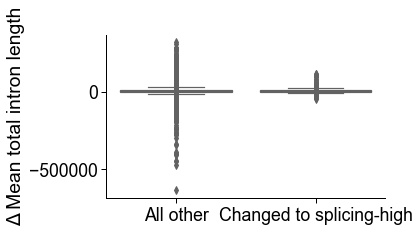

In [211]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5,3))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
new_c_dict = {'Changed to splicing-high': c_dict['splicing'],
             'All other':  c_dict['mixed']}
d2 = {True: 'Changed to splicing-high',
      False: 'All other'}
df['gene_status'] = df.changed_sect.map(d2)
# ax = sns.displot(temp2, x='alus_per_kb', hue='gene_status',
#                  palette=new_c_dict,
#                  kind='kde', common_norm=False,
#                 linewidth=3)
ax = sns.boxplot(df, y='mean_intron_len_dist', x='gene_status',
                 palette=new_c_dict)
ax.set(xlabel='', ylabel=u'Δ Mean total intron length')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<Figure size 360x216 with 0 Axes>

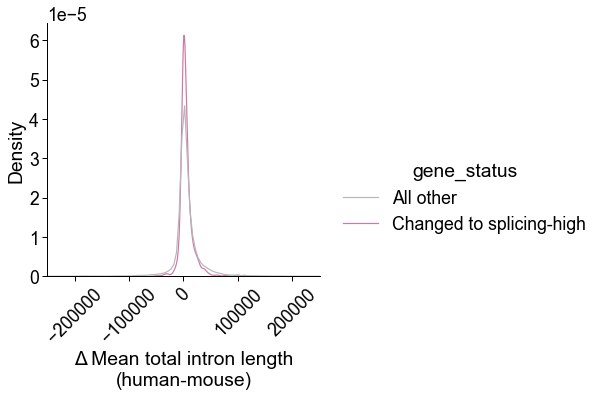

In [219]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(5,3))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
new_c_dict = {'Changed to splicing-high': c_dict['splicing'],
             'All other':  c_dict['mixed']}
d2 = {True: 'Changed to splicing-high',
      False: 'All other'}
df['gene_status'] = df.changed_sect.map(d2)
ax = sns.displot(df, x='mean_intron_len_dist',
                 hue='gene_status', kind='kde', common_norm=False,
                palette=new_c_dict)
ax = plt.gca()
ax.set(xlabel=u'Δ Mean total intron length\n(human-mouse)', xlim=(-250000,250000))
ax.tick_params(axis="x", rotation=45)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/intron_len_human_mouse.pdf', dpi=500, bbox_inches='tight')

In [148]:
a = df.loc[df.changed_sect==True].mean_intron_len_dist.tolist()
b = df.loc[df.changed_sect==False].mean_intron_len_dist.tolist()
st.ttest_ind(a,b,alternative='two-sided')

Ttest_indResult(statistic=-0.08051470541813704, pvalue=0.935829127526505)

In [149]:
np.mean(a)

5480.60501460699

In [150]:
np.mean(b)

5566.863048779961

In [78]:
# intron_df.rename({'df':'log2_mean_intron_len'}, axis=1, inplace=True)
# m_intron_df.rename({'log_mean_intron_len':'log2_mean_intron_len'}, axis=1, inplace=True)

# df = df.merge(intron_df[['gid', 'mean_intron_len', 'log2_mean_intron_len']], 
#          how='left', 
#          right_on='gid',
#          left_on='Gene stable ID')
# df.rename({'mean_intron_len':'human_mean_intron_len',
#            'log2_mean_intron_len':'human_log2_mean_intron_len'},
#           axis=1, inplace=True)
# df = df.merge(m_intron_df[['gid', 'mean_intron_len', 'log2_mean_intron_len']],
#               how='left',
#               right_on='gid',
#               left_on='Mouse gene stable ID')
# df.rename({'mean_intron_len':'m_mean_intron_len',
#            'log2_mean_intron_len':'m_log2_mean_intron_len'},
#           axis=1, inplace=True)

## What about conservation pt 2?

In [4]:
# major isoform triplets mouse match 
h_source = 'obs_mm_major'
m_source = 'obs_major'
gene_subset = ['protein_coding']
h_ver='v40_cerberus'
m_ver='vM25_cerberus'

# read in triplets and limit to source
ca = cerberus.read(cerberus_h5)
h_df = ca.triplets.loc[ca.triplets.source == h_source]

ca = cerberus.read(m_cerberus_h5)
m_df = ca.triplets.loc[ca.triplets.source == m_source]

def subset_on_dict(df, subset):
    for col, val in subset.items():
            if type(val) != list:
                val = [val]
            df = df.loc[df[col].isin(val)]
    return df

# # limit to samples if given
# if h_subset:
#     h_df = subset_on_dict(h_df, h_subset)
# if m_subset:
#     m_df = subset_on_dict(m_df, m_subset)

# get sectors for each gene
h_df = assign_gisx_sector(h_df)
m_df = assign_gisx_sector(m_df)

# merge in gene info and subset
if gene_subset:
    gene_df, _, _ = get_gtf_info(how='gene', ver=h_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    h_df = h_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    gene_df, _, _ = get_gtf_info(how='gene', ver=m_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    m_df = m_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    h_df = h_df.loc[h_df.biotype_category.isin(gene_subset)]
    m_df = m_df.loc[m_df.biotype_category.isin(gene_subset)]

# get matching gids from human and mouse
# d = os.path.dirname(__file__)
# fname = '../ref/biomart_human_to_mouse.tsv'
df = get_human_mouse_gid_table(orth_table)

df = df.merge(h_df, how='right', left_on='Gene stable ID',
              right_on='gid')

df = df.merge(m_df, how='right', left_on='Mouse gene stable ID',
              right_on='gid', suffixes=('_human', '_mouse'))

# get only genes that are both expressed
df = df.loc[~(df.sector_human.isnull())&~(df.sector_mouse.isnull())]


# get all ortholog calls
all_gids = df['Gene stable ID'].tolist()
print(len(all_gids))

# limit to splicing-->!splicing
gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist() 
print(len(gids))

13494
858


In [5]:
h_ca = cerberus.read(cerberus_h5)
# m_ca = cerberus.read(m_cerberus_h5)

h_ic = h_ca.ic.loc[h_ca.ic.gene_id.isin(df.gid_human.tolist())]
# m_ic = m_ca.ic.loc[m_ca.ic.gene_id.isin(df.gid_mouse.tolist())]
print(len(h_ic.index))
# print(len(m_ic.index))

225037
106411


In [13]:
sj_df, sj_ic_df = get_sj_from_ic(h_ic, ['v29', 'v40'])
# m_sj_df, m_sj_ic_df = get_sj_from_ic(m_ic, ['vM21', 'vM25'])

In [14]:
# e_df, e_ic_df = get_exon_from_ic(h_ic, ['v29', 'v40'])
# m_e_df, m_e_ic_df = get_exon_from_ic(m_ic, ['vM21', 'vM25'])

In [15]:
# get ids from detected ics from detected transcripts from mouse and human
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, _ = get_tpm_table(h_ab,
               how='iso',
               min_tpm=min_tpm,
               gene_subset='polya', 
               groupby=obs_col)

# limit to mouse match samples
temp = temp[get_mouse_match_samples()]
print(len(temp.index))
temp = temp.loc[temp.any(axis=1)>=min_tpm]
print(len(temp.index))
tids = temp.index.tolist()

temp = pd.DataFrame()
temp['tid'] = tids
temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
             temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
print('im here')
print(len(sj_ic_df.index))
sj_ic_df = sj_ic_df.loc[sj_ic_df.Name.isin(temp['ic'].tolist())]
print(len(sj_ic_df.index))

sj_ic_df['iid'] = sj_ic_df.Chromosome+'_'+\
                 sj_ic_df.Strand+'_'+\
                 sj_ic_df.Start.astype(str)+'_'+\
                 sj_ic_df.End.astype(str)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of isos reported: 209819
209819
175675
im here
1822386
754753


In [96]:
# m_ab = pd.read_csv(m_filt_ab, sep='\t')
# _, tids = get_tpm_table(m_ab,
#                how='iso',
#                min_tpm=min_tpm,
#                gene_subset='polya', 
#                groupby=obs_col,
#                species='mouse')
# temp = pd.DataFrame()
# temp['tid'] = tids
# temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
#              temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
# print(len(m_sj_ic_df.index))
# m_sj_ic_df = m_sj_ic_df.loc[m_sj_ic_df.Name.isin(temp['ic'].tolist())]
# print(len(m_sj_ic_df.index))

# m_sj_ic_df['iid'] = m_sj_ic_df.Chromosome+'_'+\
#                  m_sj_ic_df.Strand+'_'+\
#                  m_sj_ic_df.Start.astype(str)+'_'+\
#                  m_sj_ic_df.End.astype(str)



In [17]:
sj_ic_df.head()
print(len(sj_ic_df.index))
print(len(sj_ic_df.iid.unique().tolist()))
# sj_ic_df

754753
181166


In [18]:
sj_ic_df.head()

,Chromosome,Strand,gene_id,Name,Start,End,source,novelty,iid
0,chr1,+,ENSG00000187608,ENSG00000187608_3,1001263,1008193,"v40,v29,lapa,gtex",Known,chr1_+_1001263_1008193
1,chr1,+,ENSG00000187608,ENSG00000187608_3,1008279,1013983,"v40,v29,lapa,gtex",Known,chr1_+_1008279_1013983
2,chr1,+,ENSG00000187608,ENSG00000187608_2,1001281,1008193,"v40,v29,lapa",Known,chr1_+_1001281_1008193
3,chr1,+,ENSG00000187608,ENSG00000187608_2,1008279,1013983,"v40,v29,lapa,gtex",Known,chr1_+_1008279_1013983
4,chr1,+,ENSG00000122435,ENSG00000122435_1,100133315,100136881,"v40,v29,lapa,gtex",Known,chr1_+_100133315_100136881


In [140]:
# convert to PyRanges and get 50 nt upstream and downstream of each sj coordiate
extend = 50
len_min = extend*2
cols = ['Chromosome', 'Strand', 'Start', 'End', 'gene_id', 'Name']
h_df = sj_ic_df[cols].drop_duplicates()

n = len(h_df.index)
temp_h_df = h_df.loc[(h_df.End-h_df.Start)<len_min]
h_df = h_df.loc[~((h_df.End-h_df.Start)<len_min)]
assert len(temp_h_df.index)+len(h_df.index) == n

# introns >= 2*extension length
h_df['flank_5_End'] = h_df.Start+50
h_df['flank_3_Start'] = h_df.End-50
h_df.rename({'Start':'flank_5_Start',
             'End':'flank_3_End'},
            axis=1, inplace=True)
h_df['flank_5'] = h_df['flank_5_Start'].astype(str)+'_'+h_df['flank_5_End'].astype(str)
h_df['flank_3'] = h_df['flank_3_Start'].astype(str)+'_'+h_df['flank_3_End'].astype(str)
h_df.drop(['flank_5_Start', 'flank_5_End', 'flank_3_Start', 'flank_3_End'], axis=1, inplace=True)
h_df = h_df.melt(id_vars=['Chromosome', 'gene_id', 'Name', 'Strand'])
h_df[['Start', 'End']] = h_df.value.str.split('_', expand=True)
h_df['Start'] = h_df['Start'].astype(int)
h_df['End'] = h_df['End'].astype(int)

h_df.drop(['value', 'variable'], axis=1, inplace=True)
# print(h_df.loc[h_df.Name=='ENSG00000122435_1'])


# introns < 2*exension length just get the whole intron
h_df = pd.concat([h_df, temp_h_df], axis=0)
# print(temp_h_df.head())
# print()
# print(h_df.head())




# # h_df.head()


# # h_df['50bp_len'] = (h_df.intron_end_50bp-h_df.intron_start_50bp)
# # inds = h_df.loc[h_df['50bp_len']<0].index.tolist()
# # h_df.loc[inds, 'intron_start_50bp'] = h_df.loc[inds, 'intron_start']
# # h_df.loc[inds, 'intron_end_50bp'] = h_df.loc[inds, 'intron_end']
# # h_df['50bp_len'] = (h_df.intron_end_50bp-h_df.intron_start_50bp)
# # sns.displot(h_df, x='50bp_len', kind='hist')


# # h_df.loc[h_df['50bp_len']<0]
# # h_df = pr.PyRanges(h_df)
# # h_df = h_df.extend(-50)
# # h

1462694
1461602


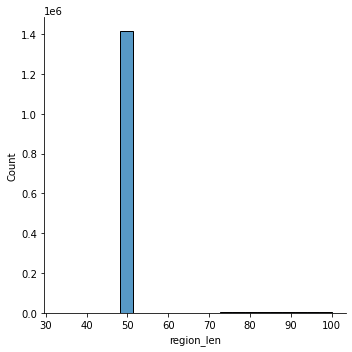

In [141]:
print(len(h_df.index))
h_df = pr.PyRanges(h_df)
h_df = h_df.merge(strand=True,
                  by=['gene_id', 'Name'],
                  count=True)
h_df = h_df.df
print(len(h_df.index))

h_df['region_len'] = h_df.End-h_df.Start
sns.displot(h_df, x='region_len')

In [142]:
h_df_back = h_df.copy(deep=True)

In [143]:
assert len(h_df.loc[(h_df.Count>1)&(h_df.region_len!=100)].index) == 0

In [144]:
h_df.drop('Count', axis=1, inplace=True)

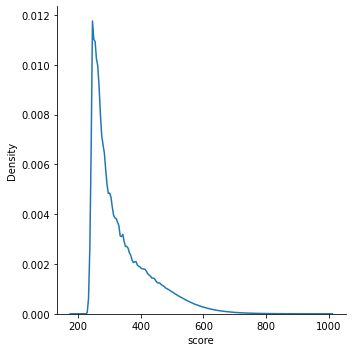

In [145]:
# read phastcons stuff in and merge with human splice flank regions
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons = cons[['Chromosome', 'Start', 'End', 'score']]
sns.displot(cons, x='score', kind='kde')
cons =  pr.PyRanges(cons)

In [213]:
h_df = h_df_back

In [214]:
h_df['thing'] = h_df.Start.astype(str)+'_'+\
                     h_df.End.astype(str)+'_'+\
                     h_df.Name
print(len(h_df.thing.unique().tolist()))
h_df = pr.PyRanges(h_df)
h_df = h_df.join(cons, report_overlap=True, how='left')
h_df = h_df.df
print(len(h_df.thing.unique().tolist()))

1461602
1461602


In [215]:
# 0 out the things that do not have any overlap
h_df.loc[h_df.Start_b == -1, ['score', 'Overlap']] = 0
assert len(h_df.loc[(h_df.score == 0)&(h_df.Start_b!=-1)].index) == 0

In [216]:
# gb_cols = ['Chromosome', 'Start', 'End', 'Strand', 'gene_id', 'Name', 'region_len']
gb_cols = ['Start', 'End', 'Name', 'region_len']
# h_df['id'] = h_df['Chromosome'].astype(str)+'_'+\
#              h_df['Start'].astype(str)+'_'+\
#              h_df['End'].astype(str)+'_'+\
#              h_df['Strand'].astype(str)+'_'+\
#              h_df['Name']
# gb_cols = ['id']
keep_cols = gb_cols+['region_score']
h_df['region_score'] = h_df.score*h_df.Overlap
h_df.head()
# 1461602
temp = h_df[keep_cols].groupby(gb_cols).sum().reset_index()
temp.head()

,Start,End,Name,region_len,region_score
0,41627,41677,ENSG00000184731_1,50,0
1,41627,41677,ENSG00000184731_2,50,0
2,41627,41677,ENSG00000184731_3,50,0
3,42758,42808,ENSG00000184731_2,50,0
4,45389,45439,ENSG00000184731_1,50,0


In [217]:
len(temp.index)

1461602

In [218]:
# by ic
temp2 = temp[['Name', 'region_len', 'region_score']].groupby('Name').sum().reset_index()
temp2['score_per_bp'] = temp2['region_score']/temp2['region_len']
temp2.head()

,Name,region_len,region_score,score_per_bp
0,ENSG00000000003_1,700,49030,70.042857
1,ENSG00000000003_10,600,40710,67.850000
2,ENSG00000000003_11,600,40152,66.920000
3,ENSG00000000003_12,700,57525,82.178571
4,ENSG00000000003_6,600,36924,61.540000


In [180]:
# by gene
temp2['gid'] = temp2['Name'].str.split('_', expand=True)[0]
temp3 = temp2[['gid', 'score_per_bp']].groupby('gid').mean().reset_index().rename({'score_per_bp':'avg_score_per_bp_for_ics'}, axis=1)
temp3

,gid,avg_score_per_bp_for_ics
0,ENSG00000000003,70.766458
1,ENSG00000000005,156.615000
2,ENSG00000000457,65.549423
3,ENSG00000000460,75.004774
4,ENSG00000000938,45.884133
...,...,...
13180,ENSG00000284753,61.800000
13181,ENSG00000284791,11.400000
13182,ENSG00000284797,15.013333
13183,ENSG00000284862,65.501582


In [184]:
temp3 = temp3.sort_values(by='avg_score_per_bp_for_ics', ascending=False)
temp3.head()

,gid,avg_score_per_bp_for_ics
6027,ENSG00000137504,737.578852
12947,ENSG00000244462,721.372500
1601,ENSG00000091010,712.670000
8591,ENSG00000162951,695.780000
4010,ENSG00000118946,677.841250


In [208]:
# h_df.loc[h_df.Name.str.contains('ENSG00000137504')]

In [187]:
temp3.head()

,gid,avg_score_per_bp_for_ics
6027,ENSG00000137504,737.578852
12947,ENSG00000244462,721.372500
1601,ENSG00000091010,712.670000
8591,ENSG00000162951,695.780000
4010,ENSG00000118946,677.841250


In [189]:
# merge with sector conservation infromation
# major isoform triplets mouse match 
h_source = 'obs_mm_major'
m_source = 'obs_major'
gene_subset = ['protein_coding']
h_ver='v40_cerberus'
m_ver='vM25_cerberus'

# read in triplets and limit to source
ca = cerberus.read(cerberus_h5)
h_df = ca.triplets.loc[ca.triplets.source == h_source]

ca = cerberus.read(m_cerberus_h5)
m_df = ca.triplets.loc[ca.triplets.source == m_source]

def subset_on_dict(df, subset):
    for col, val in subset.items():
            if type(val) != list:
                val = [val]
            df = df.loc[df[col].isin(val)]
    return df

# # limit to samples if given
# if h_subset:
#     h_df = subset_on_dict(h_df, h_subset)
# if m_subset:
#     m_df = subset_on_dict(m_df, m_subset)

# get sectors for each gene
h_df = assign_gisx_sector(h_df)
m_df = assign_gisx_sector(m_df)

# merge in gene info and subset
if gene_subset:
    gene_df, _, _ = get_gtf_info(how='gene', ver=h_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    h_df = h_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    gene_df, _, _ = get_gtf_info(how='gene', ver=m_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    m_df = m_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    h_df = h_df.loc[h_df.biotype_category.isin(gene_subset)]
    m_df = m_df.loc[m_df.biotype_category.isin(gene_subset)]

# get matching gids from human and mouse
# d = os.path.dirname(__file__)
# fname = '../ref/biomart_human_to_mouse.tsv'
df = get_human_mouse_gid_table(orth_table)

df = df.merge(h_df, how='right', left_on='Gene stable ID',
              right_on='gid')

df = df.merge(m_df, how='right', left_on='Mouse gene stable ID',
              right_on='gid', suffixes=('_human', '_mouse'))

# get only genes that are both expressed
df = df.loc[~(df.sector_human.isnull())&~(df.sector_mouse.isnull())]


# get all ortholog calls
all_gids = df['Gene stable ID'].tolist()
print(len(all_gids))


13494


In [192]:
df = df[['gid_human', 'sector_mouse', 'sector_human']]
df.rename({'gid_human': 'gid'}, axis=1, inplace=True)
df = df.merge(temp3, on='gid', how='inner')
df.head()

,gid,sector_mouse,sector_human,avg_score_per_bp_for_ics
0,ENSG00000065135,simple,tes,96.221800
1,ENSG00000093009,mixed,splicing,47.692594
2,ENSG00000102098,mixed,mixed,109.070412
3,ENSG00000141562,mixed,mixed,41.864685
4,ENSG00000105971,simple,tes,52.208750


In [193]:
df['sector_conserved'] = df.sector_mouse == df.sector_human

In [195]:
df.sector_conserved.unique()

array([False,  True])

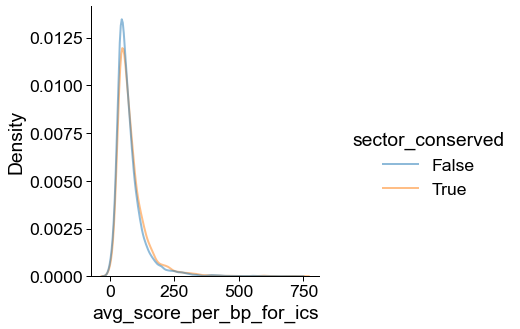

In [207]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

ax = sns.displot(df, x='avg_score_per_bp_for_ics',
                 hue='sector_conserved', kind='kde', common_norm=False,
                 linewidth=2, alpha=0.5)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

In [201]:
x = df.loc[df.sector_conserved==False].avg_score_per_bp_for_ics.tolist()
y = df.loc[df.sector_conserved==True].avg_score_per_bp_for_ics.tolist()
stat, p = st.mannwhitneyu(x,y)
print(stat)
print(p)

19434747.0
2.591943133687898e-16


## What about conservation?

In [22]:
# "parameters"
# min_cons_score = 250

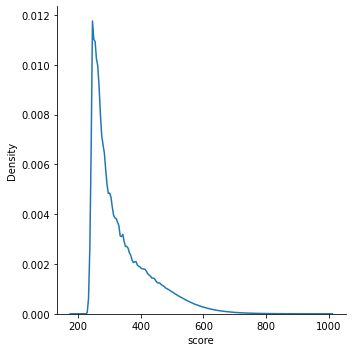

In [4]:
# read conserved elements in, threshold for a certain score
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons = cons[['Chromosome', 'Start', 'End', 'score']]
sns.displot(cons, x='score', kind='kde')

In [5]:
# cons = cons.loc[cons.score >= min_cons_score]
# cons = cons.df

In [6]:
cons['region_len'] = cons.End-cons.Start
cons.region_len.sum(axis=0)
# this is a minor subset of the human genome so I should be good to use everything

162179256

In [7]:
cons.score.min()

186

In [8]:
cons = pr.PyRanges(cons)


In [ ]:
# read gtf, limit to relevant columns
# only look at exons, calc exon len
gtf_df = pr.read_gtf(cerb_gtf, duplicate_attr=True, rename_attr=True).as_df()
gtf_df = gtf_df[['Chromosome', 'Start', 'End', 'gene_name',
                 'gene_id', 'transcript_id', 'Feature']]
gtf_df = gtf_df.loc[gtf_df.Feature=='gene']
gtf_df['gene_len'] = (gtf_df.Start-gtf_df.End).abs()

In [277]:
gtf_df = pr.PyRanges(gtf_df)
gtf_df = gtf_df.join(cons, report_overlap=True)

In [278]:
gtf_df = gtf_df.df

In [279]:
gtf_df.head()

,Chromosome,Start,End,gene_name,gene_id,transcript_id,Feature,gene_len,Start_b,End_b,score,region_len,Overlap
0,chr1,169794679,169854130,C1orf112,ENSG00000000460.16,NaN,gene,59451,169794925,169794931,255,6,6
1,chr1,169794679,169854130,C1orf112,ENSG00000000460.16,NaN,gene,59451,169794994,169795003,323,9,9
2,chr1,169794679,169854130,C1orf112,ENSG00000000460.16,NaN,gene,59451,169795023,169795030,268,7,7
3,chr1,169794679,169854130,C1orf112,ENSG00000000460.16,NaN,gene,59451,169795036,169795040,333,4,4
4,chr1,169794679,169854130,C1orf112,ENSG00000000460.16,NaN,gene,59451,169795064,169795070,361,6,6


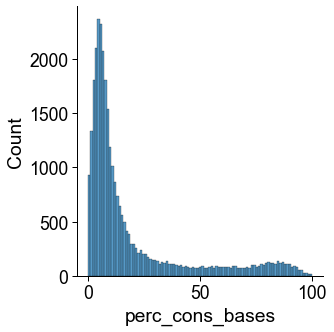

In [281]:
# compute length and % length covered in each gene
df = gtf_df[['gene_id', 'gene_len', 'Overlap']].groupby(['gene_id', 'gene_len']).sum().reset_index()
df.rename({'Overlap': 'n_cons_bases'}, axis=1, inplace=True)
df['perc_cons_bases'] = (df['n_cons_bases']/df['gene_len'])*100
sns.displot(df, x='perc_cons_bases')

In [282]:
df.to_csv('perc_cons.tsv', sep='\t')

In [283]:
# major isoform triplets mouse match 
h_source = 'obs_mm_major'
m_source = 'obs_major'
gene_subset = ['protein_coding']
h_ver='v40_cerberus'
m_ver='vM25_cerberus'

# read in triplets and limit to source
ca = cerberus.read(cerberus_h5)
h_df = ca.triplets.loc[ca.triplets.source == h_source]

ca = cerberus.read(m_cerberus_h5)
m_df = ca.triplets.loc[ca.triplets.source == m_source]

def subset_on_dict(df, subset):
    for col, val in subset.items():
            if type(val) != list:
                val = [val]
            df = df.loc[df[col].isin(val)]
    return df

# # limit to samples if given
# if h_subset:
#     h_df = subset_on_dict(h_df, h_subset)
# if m_subset:
#     m_df = subset_on_dict(m_df, m_subset)

# get sectors for each gene
h_df = assign_gisx_sector(h_df)
m_df = assign_gisx_sector(m_df)

# merge in gene info and subset
if gene_subset:
    gene_df, _, _ = get_gtf_info(how='gene', ver=h_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    h_df = h_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    gene_df, _, _ = get_gtf_info(how='gene', ver=m_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    m_df = m_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    h_df = h_df.loc[h_df.biotype_category.isin(gene_subset)]
    m_df = m_df.loc[m_df.biotype_category.isin(gene_subset)]

# get matching gids from human and mouse
# d = os.path.dirname(__file__)
# fname = '../ref/biomart_human_to_mouse.tsv'
df = get_human_mouse_gid_table(orth_table)

df = df.merge(h_df, how='right', left_on='Gene stable ID',
              right_on='gid')

df = df.merge(m_df, how='right', left_on='Mouse gene stable ID',
              right_on='gid', suffixes=('_human', '_mouse'))

# get only genes that are both expressed
df = df.loc[~(df.sector_human.isnull())&~(df.sector_mouse.isnull())]


# get all ortholog calls
all_gids = df['Gene stable ID'].tolist()
print(len(all_gids))

13494


In [285]:
df['same_sector'] = df.sector_human==df.sector_mouse

In [288]:
df2 = pd.read_csv('perc_cons.tsv', sep='\t')
df2 = df2[['gene_id', 'perc_cons_bases']]
df2['gid'] = cerberus.get_stable_gid(df2, 'gene_id')

In [291]:
temp = df[['gid_human', 'same_sector']].merge(df2,
                                              how='left',
                                              left_on='gid_human',
                                              right_on='gid')

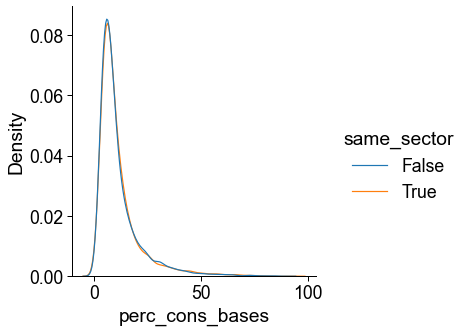

In [294]:
sns.displot(temp, x='perc_cons_bases', hue='same_sector', kind='kde', common_norm=False)

In [ ]:
# exon wise conservation
# get len covered in each exon
keep_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id', 'exon_len', 'Overlap']
gb_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id', 'exon_len']
temp = gtf_df[keep_cols].groupby(gb_cols, observed=True).sum().reset_index().rename({'Overlap': 'cons_len'}, axis=1)

In [244]:
# get total len of transcript and len covered of each transcript 
keep_cols = ['gene_name', 'gene_id', 'transcript_id', 'exon_len', 'cons_len']
gb_cols = ['gene_name', 'gene_id', 'transcript_id']
temp = temp[keep_cols].groupby(gb_cols,observed=True).sum().reset_index().rename({'exon_len': 't_len'}, axis=1)

In [245]:
# now get median % exonic conservation per gene
temp['perc_cons'] = (temp['cons_len']/temp['t_len'])*100
keep_cols = ['gene_name', 'gene_id', 'perc_cons']
gb_cols = ['gene_name', 'gene_id']
# temp = temp[keep_cols].groupby(gb_cols, observed=True).median().reset_index().rename({'perc_cons':'med_perc_cons'}, axis=1)
temp = temp[keep_cols].groupby(gb_cols, observed=True).mean().reset_index().rename({'perc_cons':'mean_perc_cons'}, axis=1)

In [246]:
temp = cerberus.add_stable_gid(temp)

In [247]:
# merge median % conservation w/ each gene
ca = cerberus.read(cerberus_h5)

In [248]:
df = ca.triplets.copy(deep=True)

In [249]:
df = df.merge(temp, how='left', left_on='gid', right_on='gene_id')

In [250]:
# df.loc[df.med_perc_cons.isnull()]
df.loc[df.mean_perc_cons.isnull()]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,gene_name,gene_id,mean_perc_cons
20,v40,ENSG00000002079,4.0,5.0,5.0,5.0,1.111111,0.395604,0.494505,0.109890,mixed,MYH16,NaN,NaN,NaN,NaN,NaN
24,v40,ENSG00000002586PARY,4.0,9.0,14.0,15.0,2.153846,0.263959,0.593909,0.142132,tes,CD99,NaN,NaN,NaN,NaN,NaN
150,v40,ENSG00000006659,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,splicing,LGALS14,NaN,NaN,NaN,NaN,NaN
160,v40,ENSG00000006788,2.0,1.0,3.0,3.0,2.000000,0.400000,0.200000,0.400000,mixed,MYH13,NaN,NaN,NaN,NaN,NaN
179,v40,ENSG00000007314,3.0,3.0,3.0,3.0,1.000000,0.428571,0.428571,0.142857,mixed,SCN4A,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567735,obs_mm_major,ENSG00000285825,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,CCDC15-DT,NaN,NaN,NaN,NaN,NaN
1567736,obs_mm_major,ENSG00000285829,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000285829,NaN,NaN,NaN,NaN,NaN
1567745,obs_mm_major,ENSG00000285886,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000285886,NaN,NaN,NaN,NaN,NaN
1567749,obs_mm_major,ENSG00000285958,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,ENSG00000285958,NaN,NaN,NaN,NaN,NaN


In [251]:
df.to_csv('mean_exon_perc_cons.tsv', sep='\t')


## Correlate number of unique exons in each species between conserved and non conserved

In [4]:
# major isoform triplets mouse match 
h_source = 'obs_mm_major'
m_source = 'obs_major'
gene_subset = ['protein_coding']
h_ver='v40_cerberus'
m_ver='vM25_cerberus'

# read in triplets and limit to source
ca = cerberus.read(cerberus_h5)
h_df = ca.triplets.loc[ca.triplets.source == h_source]

ca = cerberus.read(m_cerberus_h5)
m_df = ca.triplets.loc[ca.triplets.source == m_source]

def subset_on_dict(df, subset):
    for col, val in subset.items():
            if type(val) != list:
                val = [val]
            df = df.loc[df[col].isin(val)]
    return df

# # limit to samples if given
# if h_subset:
#     h_df = subset_on_dict(h_df, h_subset)
# if m_subset:
#     m_df = subset_on_dict(m_df, m_subset)

# get sectors for each gene
h_df = assign_gisx_sector(h_df)
m_df = assign_gisx_sector(m_df)

# merge in gene info and subset
if gene_subset:
    gene_df, _, _ = get_gtf_info(how='gene', ver=h_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    h_df = h_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    gene_df, _, _ = get_gtf_info(how='gene', ver=m_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    m_df = m_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    h_df = h_df.loc[h_df.biotype_category.isin(gene_subset)]
    m_df = m_df.loc[m_df.biotype_category.isin(gene_subset)]

# get matching gids from human and mouse
# d = os.path.dirname(__file__)
# fname = '../ref/biomart_human_to_mouse.tsv'
df = get_human_mouse_gid_table(orth_table)

df = df.merge(h_df, how='right', left_on='Gene stable ID',
              right_on='gid')

df = df.merge(m_df, how='right', left_on='Mouse gene stable ID',
              right_on='gid', suffixes=('_human', '_mouse'))

# get only genes that are both expressed
df = df.loc[~(df.sector_human.isnull())&~(df.sector_mouse.isnull())]


# get all ortholog calls
all_gids = df['Gene stable ID'].tolist()
print(len(all_gids))

# limit to splicing-->!splicing
gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist() 
print(len(gids))

13494
858


In [5]:
df.head()

,Gene stable ID,Mouse gene stable ID,source_human,gid_human,n_tss_human,n_tes_human,n_ic_human,n_iso_human,splicing_ratio_human,tss_ratio_human,...,n_iso_mouse,splicing_ratio_mouse,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,sector_mouse,gname_mouse,sample_mouse,gene_tpm_mouse,biotype_category_mouse
0,ENSG00000065135,ENSMUSG00000000001,obs_mm_major,ENSG00000065135,1.0,3.0,1.0,3.0,0.500000,0.222222,...,1.0,1.000000,0.333333,0.333333,0.333333,simple,Gnai3,NaN,NaN,protein_coding
1,ENSG00000093009,ENSMUSG00000000028,obs_mm_major,ENSG00000093009,1.0,1.0,6.0,6.0,6.000000,0.125000,...,8.0,2.400000,0.405405,0.270270,0.324324,mixed,Cdc45,NaN,NaN,protein_coding
2,ENSG00000102098,ENSMUSG00000000037,obs_mm_major,ENSG00000102098,1.0,1.0,2.0,2.0,2.000000,0.250000,...,14.0,3.200000,0.365854,0.243902,0.390244,mixed,Scml2,NaN,NaN,protein_coding
4,ENSG00000141562,ENSMUSG00000000056,obs_mm_major,ENSG00000141562,2.0,2.0,8.0,10.0,4.000000,0.250000,...,3.0,1.333333,0.230769,0.461538,0.307692,mixed,Narf,NaN,NaN,protein_coding
5,ENSG00000105971,ENSMUSG00000000058,obs_mm_major,ENSG00000105971,3.0,4.0,3.0,6.0,0.857143,0.381818,...,1.0,1.000000,0.333333,0.333333,0.333333,simple,Cav2,NaN,NaN,protein_coding


In [8]:
df['sector_conserved'] = df.sector_human==df.sector_mouse

,Gene stable ID,Mouse gene stable ID,source_human,gid_human,n_tss_human,n_tes_human,n_ic_human,n_iso_human,splicing_ratio_human,tss_ratio_human,...,splicing_ratio_mouse,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,sector_mouse,gname_mouse,sample_mouse,gene_tpm_mouse,biotype_category_mouse,sector_conserved
0,ENSG00000065135,ENSMUSG00000000001,obs_mm_major,ENSG00000065135,1.0,3.0,1.0,3.0,0.500000,0.222222,...,1.000000,0.333333,0.333333,0.333333,simple,Gnai3,NaN,NaN,protein_coding,False
1,ENSG00000093009,ENSMUSG00000000028,obs_mm_major,ENSG00000093009,1.0,1.0,6.0,6.0,6.000000,0.125000,...,2.400000,0.405405,0.270270,0.324324,mixed,Cdc45,NaN,NaN,protein_coding,False
2,ENSG00000102098,ENSMUSG00000000037,obs_mm_major,ENSG00000102098,1.0,1.0,2.0,2.0,2.000000,0.250000,...,3.200000,0.365854,0.243902,0.390244,mixed,Scml2,NaN,NaN,protein_coding,True
4,ENSG00000141562,ENSMUSG00000000056,obs_mm_major,ENSG00000141562,2.0,2.0,8.0,10.0,4.000000,0.250000,...,1.333333,0.230769,0.461538,0.307692,mixed,Narf,NaN,NaN,protein_coding,True
5,ENSG00000105971,ENSMUSG00000000058,obs_mm_major,ENSG00000105971,3.0,4.0,3.0,6.0,0.857143,0.381818,...,1.000000,0.333333,0.333333,0.333333,simple,Cav2,NaN,NaN,protein_coding,False


In [9]:
h_ca = cerberus.read(cerberus_h5)
m_ca = cerberus.read(m_cerberus_h5)

h_ic = h_ca.ic.loc[h_ca.ic.gene_id.isin(df.gid_human.tolist())]
m_ic = m_ca.ic.loc[m_ca.ic.gene_id.isin(df.gid_mouse.tolist())]
print(len(h_ic.index))
print(len(m_ic.index))

225037
106411


In [51]:
e_df, e_ic_df = get_exon_from_ic(h_ic, ['v29', 'v40'])
m_e_df, m_e_ic_df = get_exon_from_ic(m_ic, ['vM21', 'vM25'])

In [45]:
e_ic_df.head()

,Chromosome,Strand,gene_id,Name,Start,End,source,novelty
0,chr1,+,ENSG00000187608,ENSG00000187608_3,1008193,1008279,"v40,v29,lapa,gtex",Known
1,chr1,+,ENSG00000187608,ENSG00000187608_2,1008193,1008279,"v40,v29,lapa,gtex",Known
2,chr1,+,ENSG00000122435,ENSG00000122435_1,100136881,100136928,"v40,v29,lapa,gtex",Known
3,chr1,+,ENSG00000122435,ENSG00000122435_1,100137018,100137085,"v40,v29,lapa,gtex",Known
4,chr1,+,ENSG00000122435,ENSG00000122435_1,100139648,100139711,"v40,v29,lapa,gtex",Known


In [46]:
# get ids from detected ics from detected transcripts from mouse and human
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, _ = get_tpm_table(h_ab,
               how='iso',
               min_tpm=min_tpm,
               gene_subset='polya', 
               groupby=obs_col)

# limit to mouse match samples
temp = temp[get_mouse_match_samples()]
print(len(temp.index))
temp = temp.loc[temp.any(axis=1)>=min_tpm]
print(len(temp.index))
tids = temp.index.tolist()

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of isos reported: 209819
209819
175675


In [47]:
temp = pd.DataFrame()
temp['tid'] = tids
temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
             temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
print('im here')
print(len(e_ic_df.index))
e_ic_df = e_ic_df.loc[e_ic_df.Name.isin(temp['ic'].tolist())]
print(len(e_ic_df.index))

im here
1599873
669801


In [48]:
e_ic_df['eid'] = e_ic_df.Chromosome+'_'+\
                 e_ic_df.Strand+'_'+\
                 e_ic_df.Start.astype(str)+'_'+\
                 e_ic_df.End.astype(str)

In [49]:
# total unique, detected in mm samples exons / gene
h_temp = e_ic_df[['gene_id', 'eid']].groupby('gene_id').nunique().reset_index().rename({'eid':'n_unique_exons'}, axis=1)
h_temp.head()

,gene_id,n_unique_exons
0,ENSG00000000003,6
1,ENSG00000000005,5
2,ENSG00000000457,13
3,ENSG00000000460,25
4,ENSG00000000938,15


In [52]:
m_ab = pd.read_csv(m_filt_ab, sep='\t')
_, tids = get_tpm_table(m_ab,
               how='iso',
               min_tpm=min_tpm,
               gene_subset='polya', 
               groupby=obs_col,
               species='mouse')
temp = pd.DataFrame()
temp['tid'] = tids
temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
             temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
print(len(m_e_ic_df.index))
m_e_ic_df = m_e_ic_df.loc[m_e_ic_df.Name.isin(temp['ic'].tolist())]
print(len(m_e_ic_df.index))

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 153398
# isos >= 1 tpm: 142504
Applying gene type and novelty subset
Averaging over biosample
Found 32 total samples
Number of isos reported: 139335
740775
538996


In [42]:
temp.head()

,tid,ic
0,"ENSMUSG00000051951[2,2,3]",ENSMUSG00000051951_2
1,"ENSMUSG00000089699[1,1,1]",ENSMUSG00000089699_1
2,"ENSMUSG00000025902[1,2,1]",ENSMUSG00000025902_2
3,"ENSMUSG00000025902[1,2,3]",ENSMUSG00000025902_2
4,"ENSMUSG00000025902[1,4,1]",ENSMUSG00000025902_4


In [55]:
m_e_ic_df['eid'] = m_e_ic_df.Chromosome+'_'+\
                 m_e_ic_df.Strand+'_'+\
                 m_e_ic_df.Start.astype(str)+'_'+\
                 m_e_ic_df.End.astype(str)

In [56]:
# total unique, detected in mm samples exons / gene
m_temp = m_e_ic_df[['gene_id', 'eid']].groupby('gene_id').nunique().reset_index().rename({'eid':'n_unique_exons'}, axis=1)
m_temp.head()

,gene_id,n_unique_exons
0,ENSMUSG00000000001,7
1,ENSMUSG00000000028,19
2,ENSMUSG00000000037,25
3,ENSMUSG00000000056,11
4,ENSMUSG00000000058,1


In [63]:
temp = df[['gid_human', 'gid_mouse', 'sector_conserved']]
temp = temp.merge(m_temp, how='inner', left_on='gid_mouse', right_on='gene_id', suffixes=('', '_mouse'))
temp = temp.merge(h_temp, how='inner', left_on='gid_human', right_on='gene_id', suffixes=('', '_human'))
temp

,gid_human,gid_mouse,sector_conserved,gene_id,n_unique_exons,gene_id_human,n_unique_exons_human
0,ENSG00000065135,ENSMUSG00000000001,False,ENSMUSG00000000001,7,ENSG00000065135,7
1,ENSG00000093009,ENSMUSG00000000028,False,ENSMUSG00000000028,19,ENSG00000093009,25
2,ENSG00000102098,ENSMUSG00000000037,True,ENSMUSG00000000037,25,ENSG00000102098,13
3,ENSG00000141562,ENSMUSG00000000056,True,ENSMUSG00000000056,11,ENSG00000141562,17
4,ENSG00000105971,ENSMUSG00000000058,False,ENSMUSG00000000058,1,ENSG00000105971,1
...,...,...,...,...,...,...,...
12277,ENSG00000160948,ENSMUSG00000115987,True,ENSMUSG00000115987,11,ENSG00000160948,15
12278,ENSG00000213563,ENSMUSG00000116138,True,ENSMUSG00000116138,1,ENSG00000213563,3
12279,ENSG00000058729,ENSMUSG00000116564,True,ENSMUSG00000116564,10,ENSG00000058729,8
12280,ENSG00000113108,ENSMUSG00000117679,True,ENSMUSG00000117679,10,ENSG00000113108,14


False
For genes w/ False sector conserved, pearson r=0.8938009495533267 and pval=0.0
For genes w/ False sector conserved, spearman rho=0.9044496203102355 and pval=0.0
True
For genes w/ True sector conserved, pearson r=0.9511136235478957 and pval=0.0
For genes w/ True sector conserved, spearman rho=0.9443632906115738 and pval=0.0


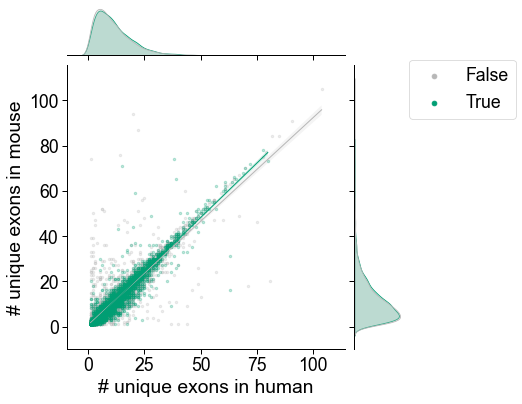

In [145]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
# fig, ax = plt.subplots(figsize=(6, 6))

c_dict, order = get_sector_colors()
c_dict_2, order_2 = get_feat_triplet_colors(cats=None)
new_c_dict = {True: c_dict_2['triplet'],
              False:  c_dict['mixed']}

g = sns.jointplot(data=temp, x='n_unique_exons_human', y='n_unique_exons',
                  hue='sector_conserved', palette=new_c_dict,
                  joint_kws={'s': 0},
                  marginal_kws={'common_norm': False})
for i, v in enumerate(temp.sector_conserved.unique()):
    print(v)
    temp2 = temp.loc[temp.sector_conserved==v]
    r, pval = stats.pearsonr(temp2.n_unique_exons_human.tolist(), temp2.n_unique_exons.tolist())
    
    print(f'For genes w/ {v} sector conserved, pearson r={r} and pval={pval}')
    rho, pval = stats.spearmanr(temp2.n_unique_exons_human.tolist(), temp2.n_unique_exons.tolist())
    print(f'For genes w/ {v} sector conserved, spearman rho={rho} and pval={pval}')
    
    sns.regplot(data=temp2, x='n_unique_exons_human',
                y='n_unique_exons', ax=g.ax_joint, color=new_c_dict[v],
                scatter_kws={'s': 6,
                             'alpha': 0.25},
                line_kws={'linewidth': 1})
    
_ = g.ax_joint.set(xlabel='# unique exons in human', ylabel='# unique exons in mouse')
legend = g.ax_joint.legend(title='Sector conserved')    
g.ax_joint.legend(bbox_to_anchor=(1.2, 1.05))
plt.savefig('figures/human_mouse_n_exons_cons.pdf', dpi=500)

In [148]:
# also do this for splicing conserved vs. non splicing conserved
temp2 = df[['gid_human', 'sector_mouse']]
temp = temp.merge(temp2, how='inner', on='gid_human')
temp['splicing_conserved'] = (temp.sector_conserved==True)&(temp.sector_mouse=='splicing')

In [153]:
temp['n_exon_ratio'] = temp.n_unique_exons_human/temp.n_unique_exons

In [149]:
temp.to_csv('n_unique_detected_exons_human_mouse.tsv', sep='\t', index=False)

In [150]:
temp.head()

,gid_human,gid_mouse,sector_conserved,gene_id,n_unique_exons,gene_id_human,n_unique_exons_human,n_exon_ratio,sector_mouse,splicing_conserved
0,ENSG00000065135,ENSMUSG00000000001,False,ENSMUSG00000000001,7,ENSG00000065135,7,1.000000,simple,False
1,ENSG00000093009,ENSMUSG00000000028,False,ENSMUSG00000000028,19,ENSG00000093009,25,1.315789,mixed,False
2,ENSG00000102098,ENSMUSG00000000037,True,ENSMUSG00000000037,25,ENSG00000102098,13,0.520000,mixed,False
3,ENSG00000141562,ENSMUSG00000000056,True,ENSMUSG00000000056,11,ENSG00000141562,17,1.545455,mixed,False
4,ENSG00000105971,ENSMUSG00000000058,False,ENSMUSG00000000058,1,ENSG00000105971,1,1.000000,simple,False


False
For genes w/ False sector conserved, pearson r=0.9181952932168358 and pval=0.0
For genes w/ False sector conserved, spearman rho=0.9216445413741043 and pval=0.0
True
For genes w/ True sector conserved, pearson r=0.8959782708716719 and pval=3.065710183821788e-104
For genes w/ True sector conserved, spearman rho=0.8856270870501869 and pval=1.3202658439140943e-98


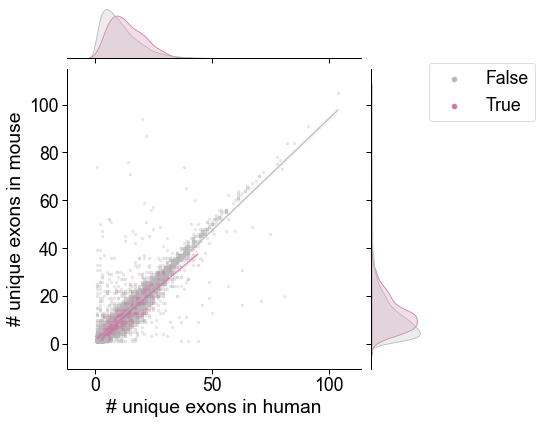

In [13]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
# fig, ax = plt.subplots(figsize=(6, 6))

c_dict, order = get_sector_colors()
c_dict_2, order_2 = get_feat_triplet_colors(cats=None)
new_c_dict = {True: c_dict_2['ic'],
              False:  c_dict['mixed']}

g = sns.jointplot(data=temp, x='n_unique_exons_human', y='n_unique_exons',
                  hue='splicing_conserved', palette=new_c_dict,
                  joint_kws={'s': 0},
                  marginal_kws={'common_norm': False})
for i, v in enumerate(temp.splicing_conserved.unique()):
    print(v)
    temp2 = temp.loc[temp.splicing_conserved==v]
    r, pval = stats.pearsonr(temp2.n_unique_exons_human.tolist(), temp2.n_unique_exons.tolist())
    
    print(f'For genes w/ {v} sector conserved, pearson r={r} and pval={pval}')
    rho, pval = stats.spearmanr(temp2.n_unique_exons_human.tolist(), temp2.n_unique_exons.tolist())
    print(f'For genes w/ {v} sector conserved, spearman rho={rho} and pval={pval}')
    
    sns.regplot(data=temp2, x='n_unique_exons_human',
                y='n_unique_exons', ax=g.ax_joint, color=new_c_dict[v],
                scatter_kws={'s': 6,
                             'alpha': 0.25},
                line_kws={'linewidth': 1})
    
_ = g.ax_joint.set(xlabel='# unique exons in human', ylabel='# unique exons in mouse')
legend = g.ax_joint.legend(title='Sector conserved')    
g.ax_joint.legend(bbox_to_anchor=(1.2, 1.05))
plt.savefig('figures/human_mouse_n_exons_spl_cons.pdf', dpi=500)

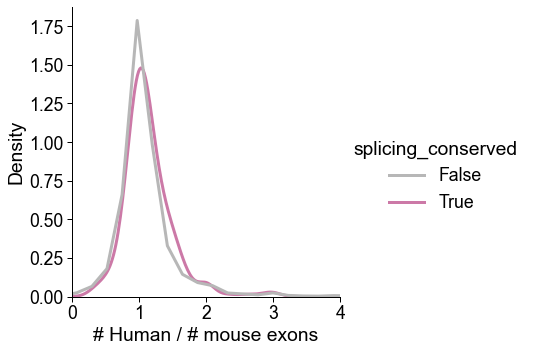

In [17]:
ax = sns.displot(temp,
            x='n_exon_ratio',
            hue='splicing_conserved',
            kind='kde',
            palette=new_c_dict, 
            common_norm=False,
            linewidth=3)
ax.set(xlim=(0,4), xlabel='# Human / # mouse exons')
plt.savefig('figures/human_mouse_n_exons_spl_cons_ratio.pdf', dpi=500)

In [10]:
temp = pd.read_csv('n_unique_detected_exons_human_mouse.tsv', sep='\t')

In [12]:
x = temp.loc[temp.splicing_conserved==False].n_exon_ratio.tolist()
y = temp.loc[temp.splicing_conserved==True].n_exon_ratio.tolist()
stat, p = st.mannwhitneyu(x,y)
print(stat)
print(p)

1535232.5
0.0002520892957155176


## Plot distances of things w/ conserved sectors vs. non-conserved sectors

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']
phastcons = od+config['ref']['phastcons100']['txt']


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
m_cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='mouse')[0]



m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = od+config['ref']['orth_genes']

mouse_ver = 'vM25_cerberus'

In [2]:
df = pd.read_csv('human_mouse_sect_cons.tsv', sep='\t')

In [3]:
df[[c for c in df.columns if 'sector' in c]]
df['sector_conserved'] = df['sector_sample_mm_det_centroid'] == df['sector_sample_det_mouse_centroid']
df.head()

,source_sample_mm_det_centroid,gid_sample_mm_det_centroid,n_tss_sample_mm_det_centroid,n_tes_sample_mm_det_centroid,n_ic_sample_mm_det_centroid,n_iso_sample_mm_det_centroid,splicing_ratio_sample_mm_det_centroid,tss_ratio_sample_mm_det_centroid,tes_ratio_sample_mm_det_centroid,spl_ratio_sample_mm_det_centroid,...,sector_sample_det_mouse_centroid,gname_sample_det_mouse_centroid,sample_sample_det_mouse_centroid,gene_tpm_sample_det_mouse_centroid,Mouse gene stable ID_sample_det_mouse_centroid,gid_stable_sample_det_mouse_centroid,biotype_sample_det_mouse_centroid,dist,z_score,sector_conserved
0,sample_mm_det_centroid,ENSG00000112699,1.777778,1.777778,2.777778,2.777778,1.500000,0.332252,0.365427,0.302321,...,mixed,Gmds,NaN,NaN,ENSMUSG00000038372,ENSMUSG00000038372,protein_coding,0.020545,-1.246395,True
1,sample_mm_det_centroid,ENSG00000112936,2.500000,3.000000,4.500000,6.000000,1.388889,0.352234,0.398625,0.249141,...,simple,C7,NaN,NaN,ENSMUSG00000079105,ENSMUSG00000079105,protein_coding,0.068127,-0.577519,False
2,sample_mm_det_centroid,ENSG00000147650,1.888889,2.444444,3.111111,4.111111,1.499471,0.313136,0.410024,0.276839,...,mixed,Lrp12,NaN,NaN,ENSMUSG00000022305,ENSMUSG00000022305,protein_coding,0.112779,0.050155,True
3,sample_mm_det_centroid,ENSG00000157593,2.111111,1.000000,6.333333,6.555556,4.018519,0.300077,0.144191,0.555732,...,splicing,Slc35b2,NaN,NaN,ENSMUSG00000037089,ENSMUSG00000037089,protein_coding,0.155524,0.651041,True
4,sample_mm_det_centroid,ENSG00000157600,1.333333,2.000000,2.000000,3.000000,1.088889,0.303030,0.444444,0.252525,...,mixed,Tmem164,NaN,NaN,ENSMUSG00000047045,ENSMUSG00000047045,protein_coding,0.082907,-0.369758,True


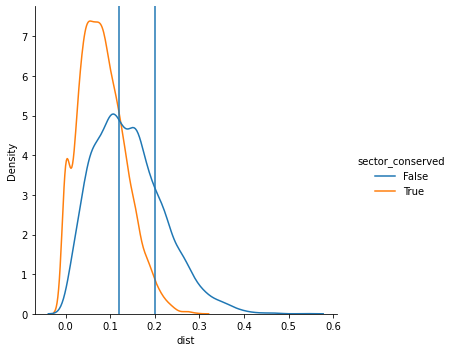

In [4]:
sns.displot(df, kind='kde', hue='sector_conserved', x='dist', common_norm=False)
plt.axvline(x=0.12)
plt.axvline(x=0.2)

In [5]:
dist = 0.12
n = len(df.index)
n_num = len(df.loc[df.dist>=dist].index)
print(f'({((n_num/n)*100):.2f}% ({n_num}/{n}) of 1:1 pc human-mouse orthologs have a distance >= {dist}')

(37.99% (5127/13494) of 1:1 pc human-mouse orthologs have a distance >= 0.12


In [6]:
dist = 0.2
n = len(df.index)
n_num = len(df.loc[df.dist>=dist].index)
print(f'({((n_num/n)*100):.2f}% ({n_num}/{n}) of 1:1 pc human-mouse orthologs have a distance >= {dist}')

(10.98% (1481/13494) of 1:1 pc human-mouse orthologs have a distance >= 0.2
